In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [39]:
df = pd.read_csv("data/consumption_temp.csv")
df = df.set_index('time')
df.index = pd.to_datetime(df.index)

8641
8641
8641
8641
8641
6289


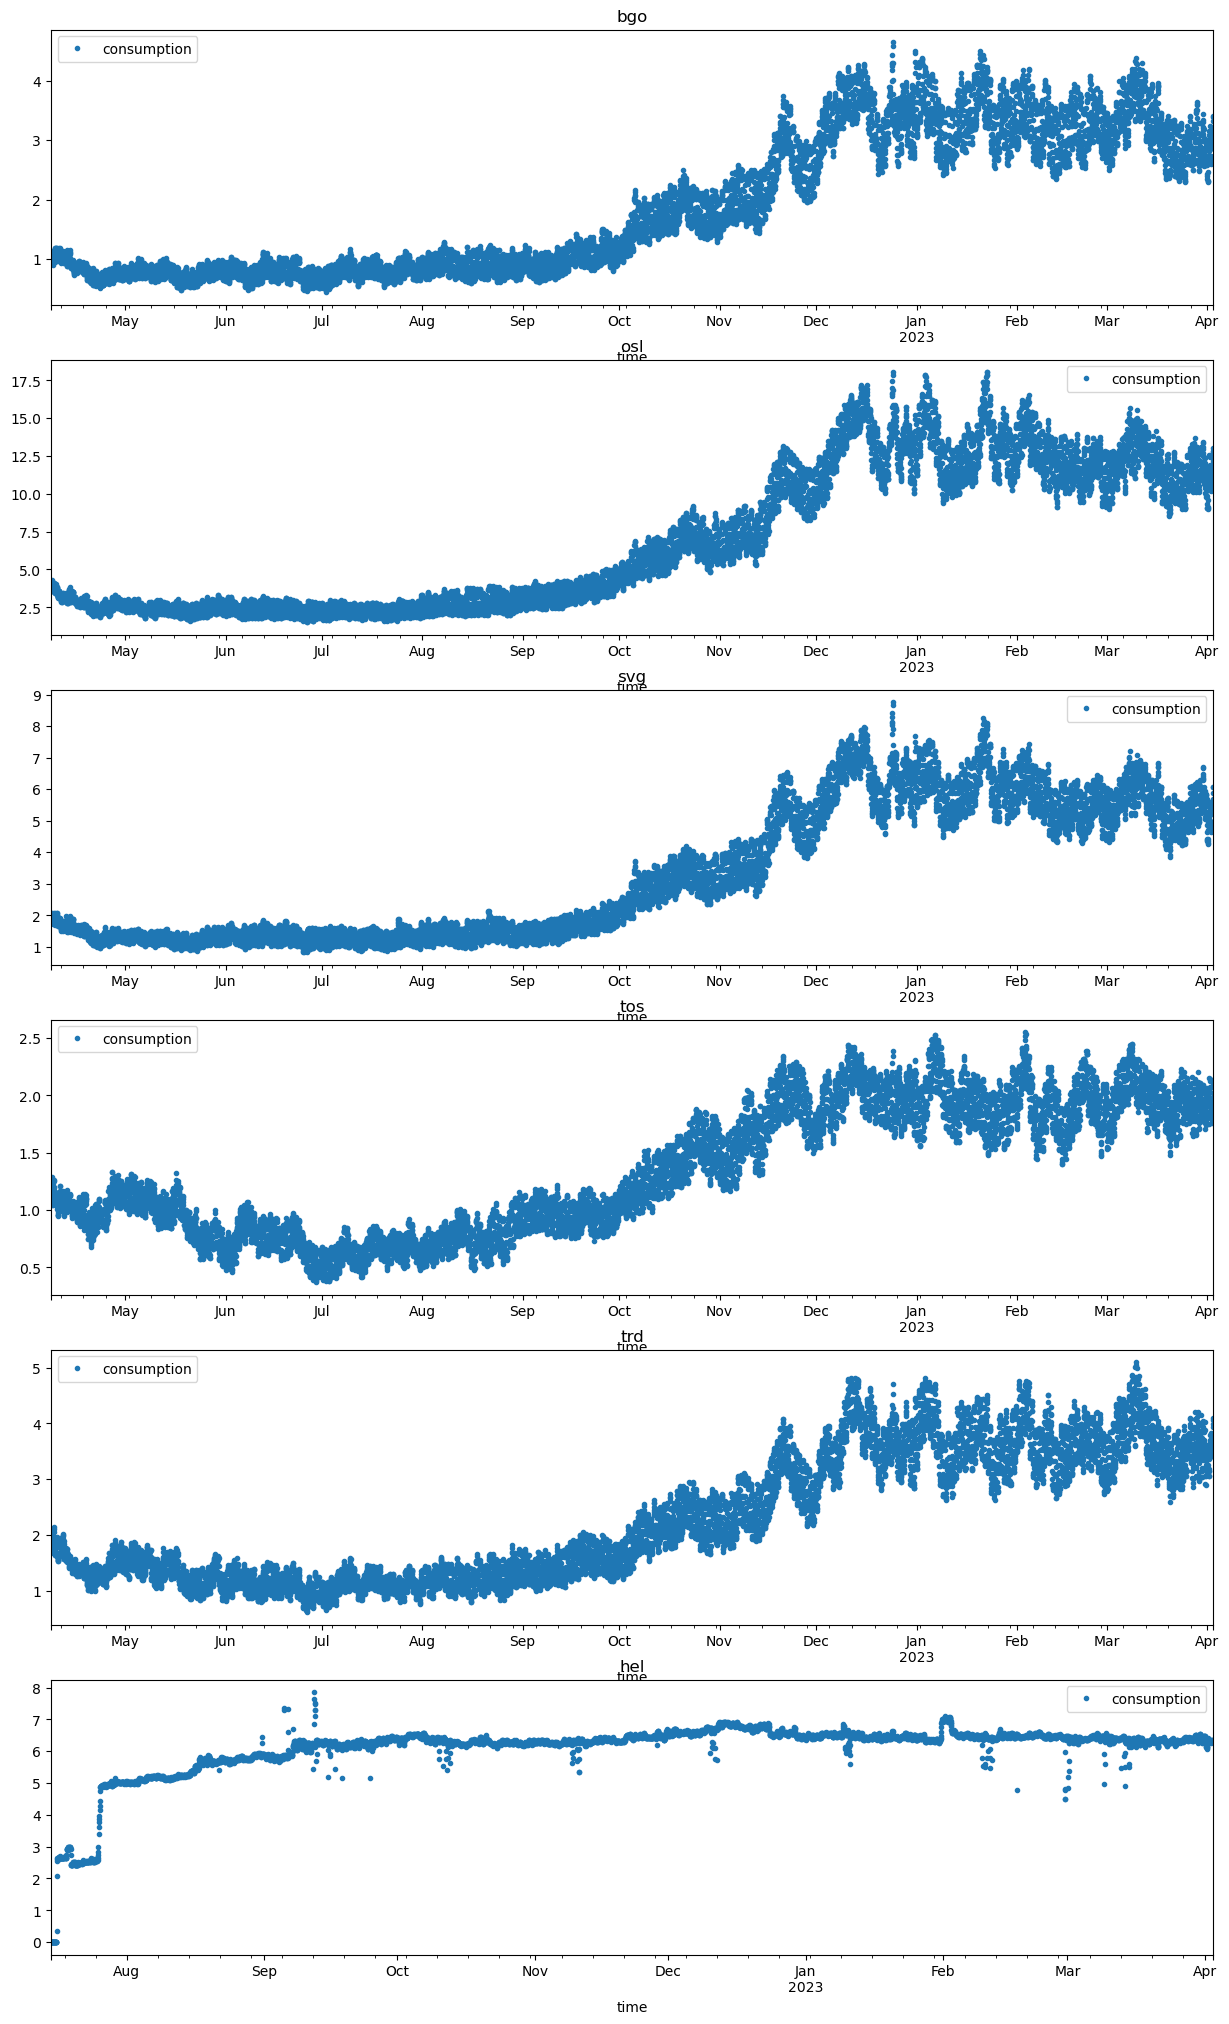

In [40]:
locations = [bgo, osl, svg, tos, trd, hel]

fig, axs = plt.subplots(6, 1, figsize=(15,25), sharex=False)
bgo[["consumption", ]].plot(ax=axs[0], title="bgo", style=".")
osl[["consumption",]].plot(ax=axs[1], title="osl", style=".")
svg[["consumption",]].plot(ax=axs[2], title="svg", style=".")
tos[["consumption", ]].plot(ax=axs[3], title="tos", style=".")
trd[["consumption",]].plot(ax=axs[4], title="trd", style=".")
hel[["consumption", ]].plot(ax=axs[5], title="hel", style=".")

for df in locations:
    print(df.shape[0])

<Axes: xlabel='time'>

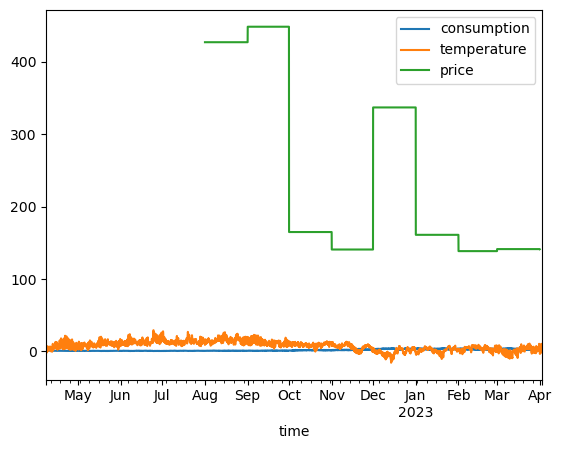

In [104]:
bgo.plot()

## Simple train/test split

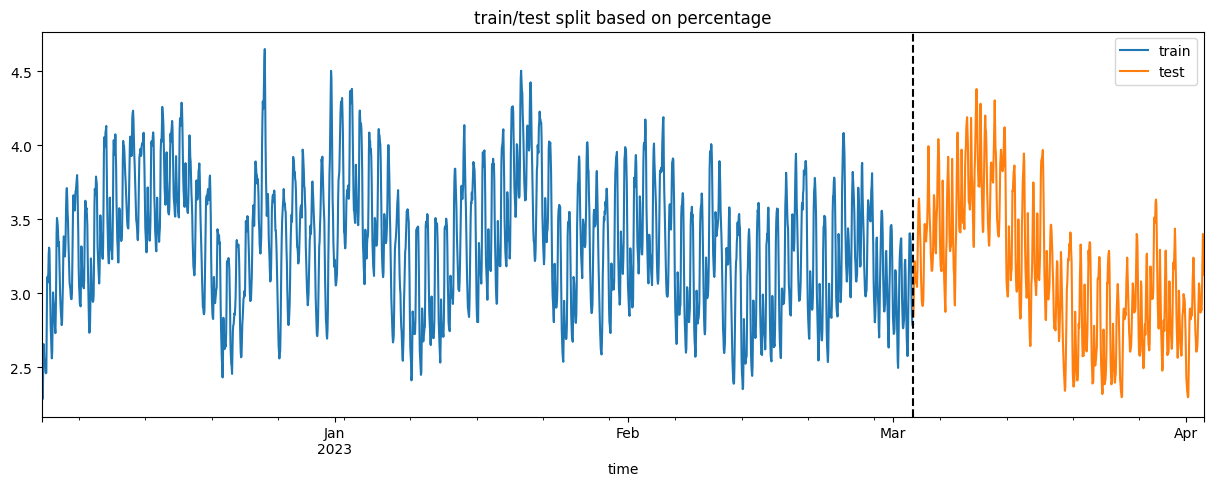

In [41]:
# only use 2023 data
bgo = bgo.query('time > "12-2022"')

# Determine the split point
split_idx = int(len(bgo) * 0.75)

# Split the data
train = bgo.iloc[:split_idx]
test = bgo.iloc[split_idx:]

# Plot the data
fig, ax = plt.subplots(figsize=(15,5))
train["consumption"].plot(ax=ax, label="train", title="train/test split based on percentage")
test["consumption"].plot(ax=ax, label="test")
ax.axvline(train.index[-1], color="black", ls="--")
ax.legend(["train", "test"])
plt.show()


<Axes: title={'center': 'One week of data'}, xlabel='time'>

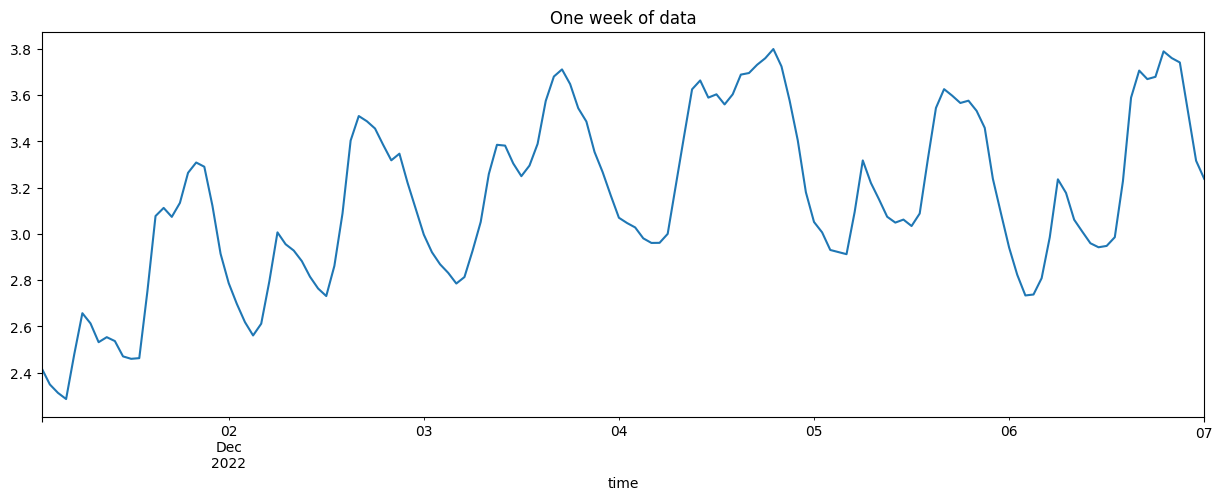

In [42]:
bgo.loc[(bgo.index > "12-01-2022") & (bgo.index <= "12-07-2022")]["consumption"].plot(
    figsize=(15,5), title="One week of data")

## Model Creation

In [43]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # Creating daily lag features for up to 3 days
    for lag in range(24, 24*3, 24):
        df['lag_daily_' + str((lag))] = df['consumption'].shift(lag)
    # Rolling standard deviation
    df['rolling_std_1d'] = df['consumption'].rolling(window=24).std()
    df.dropna(inplace=True)
   
    return df

In [44]:
train = create_features(train)
test = create_features(test)
train.head()

,location,consumption,temperature,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_daily_24,lag_daily_48,rolling_std_1d
time,,,,,,,,,,,,,,
2022-12-03 01:00:00,bergen,2.920392,-2.3,1,5,4,12,2022,337,3,48,2.697050,2.418240,0.296423
2022-12-03 02:00:00,bergen,2.868295,-2.6,2,5,4,12,2022,337,3,48,2.618148,2.348631,0.285441
2022-12-03 03:00:00,bergen,2.831228,-2.8,3,5,4,12,2022,337,3,48,2.560507,2.312211,0.270538
2022-12-03 04:00:00,bergen,2.785022,-2.9,4,5,4,12,2022,337,3,48,2.611276,2.285586,0.260322
2022-12-03 05:00:00,bergen,2.813031,-2.6,5,5,4,12,2022,337,3,48,2.794582,2.478596,0.259528


In [45]:
FEATURES = ["hour", "dayofyear", "temperature", "lag_daily_24", "rolling_std_1d"]
TARGET = 'consumption'

In [46]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [47]:
reg = xgb.XGBRegressor(booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01,
                       )
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:0.43110	validation_1-rmse:0.51241
[100]	validation_0-rmse:0.25220	validation_1-rmse:0.32663
[200]	validation_0-rmse:0.19527	validation_1-rmse:0.27329


[300]	validation_0-rmse:0.17395	validation_1-rmse:0.25357
[400]	validation_0-rmse:0.16162	validation_1-rmse:0.23942
[500]	validation_0-rmse:0.15277	validation_1-rmse:0.23072
[600]	validation_0-rmse:0.14670	validation_1-rmse:0.22563
[700]	validation_0-rmse:0.14235	validation_1-rmse:0.22291
[800]	validation_0-rmse:0.13848	validation_1-rmse:0.22017
[900]	validation_0-rmse:0.13538	validation_1-rmse:0.21777
[999]	validation_0-rmse:0.13310	validation_1-rmse:0.21656


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance

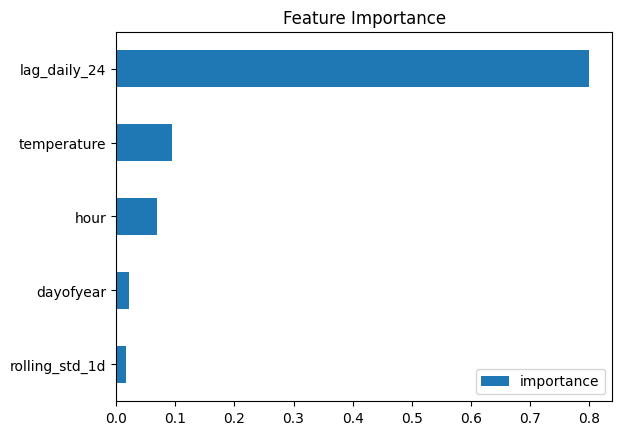

In [48]:

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

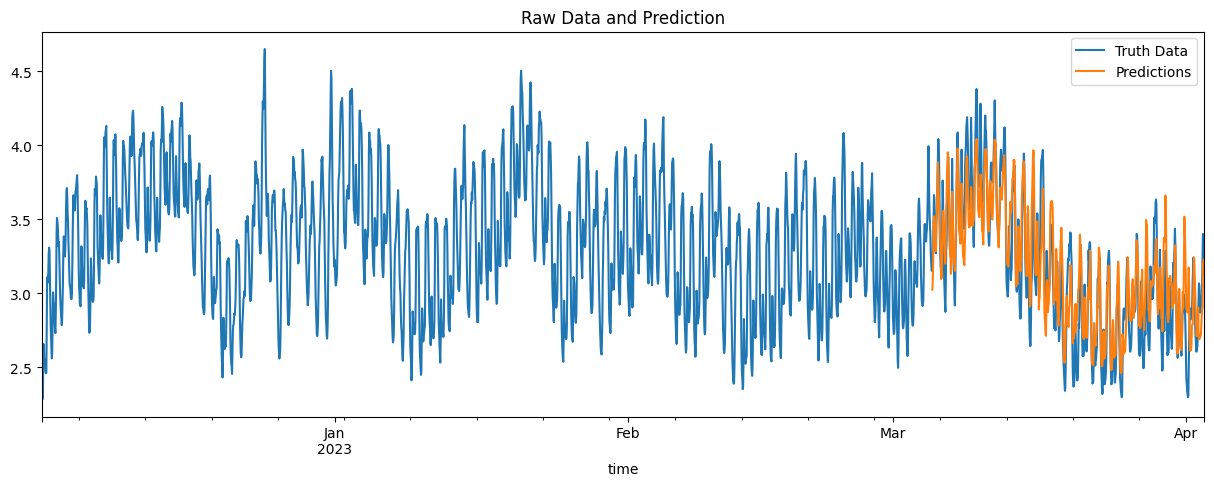

In [49]:
test['prediction'] = reg.predict(X_test)
test.head()
bgo = bgo.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = bgo[['consumption']].plot(figsize=(15, 5), style="-")
bgo['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

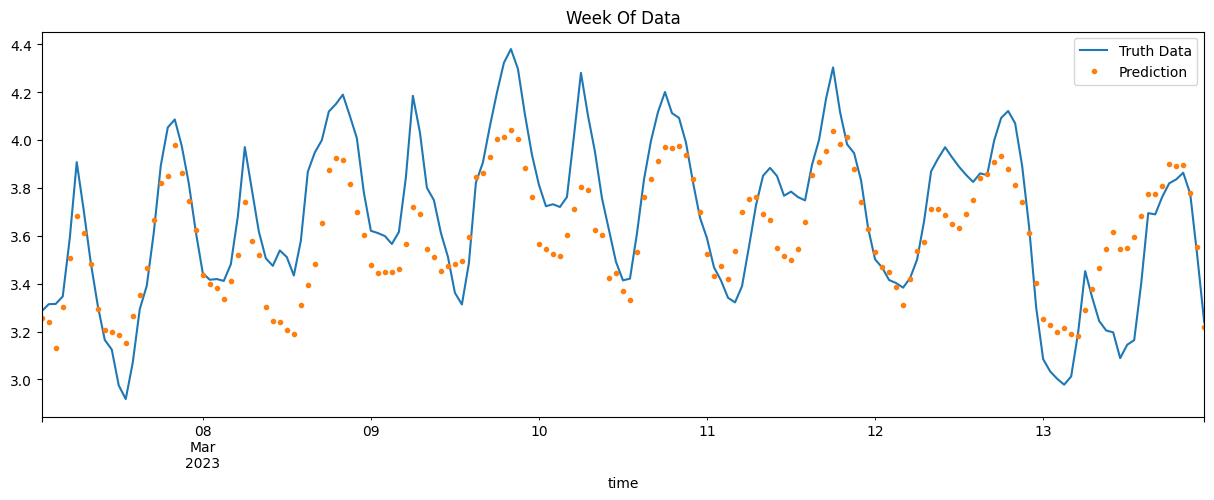

In [51]:
ax = bgo.loc[(bgo.index > '03-07-2023') & (bgo.index < '03-14-2023')]['consumption'] \
    .plot(figsize=(15, 5), title='Week Of Data')
bgo.loc[(bgo.index > '03-07-2023') & (bgo.index < '03-14-2023')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

ax = bgo.loc[(bgo.index > '04-01-2018') & (bgo.index < '04-08-2018')]['consu'] \
    .plot(figsize=(15, 5), title='Week Of Data')
bgo.loc[(bgo.index > '04-01-2018') & (bgo.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(test['consumption'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.22


In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-04-01    0.322990
2023-03-20    0.258169
2023-03-29    0.255499
2023-03-27    0.237162
2023-03-19    0.232441
2023-03-15    0.228948
2023-03-08    0.218967
2023-03-18    0.214796
2023-03-16    0.210465
2023-03-09    0.193795
Name: error, dtype: float64